In [21]:
# Deep Learning for Autonomous Driving
# Project 1: Understanding Multimodal Driving Data

In [22]:
%matplotlib inline
import os
import io
import math
import pickle
import PIL.Image
from PIL import Image
import cv2 as cv
import numpy as np
from load_data import load_data
from matplotlib import pyplot as plt
from IPython.display import clear_output, Image, display
from scipy import integrate, interpolate
def load_data(data_path):
    # Load data dictionary from data_path.
    with open(data_path, 'rb') as fp:
        data = pickle.load(fp)
    return data

# https://stackoverflow.com/questions/34643747/ipython-notebook-jupyter-opencv-cv2-and-plotting
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# OpenCV documentation https://docs.opencv.org/master/
# Note that it's mainly written with C/C++ in mind. However, Python functions are given as well.

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

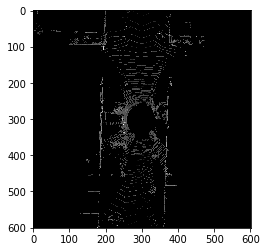

In [23]:
# Problem 1. Bird's Eye View

# load data
segmentation_data_path = os.path.join('data', 'segmentation_data.p')
segmentation_data = load_data(segmentation_data_path)

# point cloud of the scene of type (x [m], y [m], z [m], reflectance intensity [0,1]), (num_points x 4) numpy.array object
velodyne = segmentation_data["velodyne"]

def lidar2bev(lidar, resolution, front_range, side_range):
    x_lidar = lidar[:,0]
    y_lidar = lidar[:,1]
    z_lidar = lidar[:,2]
    r_lidar = lidar[:,3]
    
    # Filter out points that are not in the desired box of bev view
    indices_x = np.logical_and((x_lidar >= front_range[0]), x_lidar <= front_range[1])
    indices_y = np.logical_and((y_lidar >= side_range[0]), y_lidar <= side_range[1])
    indices = np.argwhere(np.logical_and(indices_x,indices_y)).flatten()
    
    filtered_lidar = lidar[indices]    
    x_lidar, y_lidar, z_lidar, r_lidar = x_lidar[indices], y_lidar[indices], z_lidar[indices], r_lidar[indices]
    
    # Shift to (0,0) and divide by resolution to obtain the image coordinates
    # Note that lidar coordinates system is different than image coordinates
    # lidar: y is positive left img: y is positive right
    # lidar: x is positive forward img: x is positive down
    x_image = -np.rint((x_lidar - front_range[1]) / resolution).astype(np.int32)
    y_image = -np.rint((y_lidar - side_range[1]) / resolution).astype(np.int32)
    
    # Create the image
    width = int(((side_range[1] - side_range[0]) // resolution)) + 2
    height = int(((front_range[1] - front_range[0]) // resolution)) + 2
    image = np.zeros((height, width))
    
    # Now we want to take highest points if multiple points overlap
    # so just sort the points ascending based on x,y,z coordinates respectively
    #later the one with highest z will always overwrite the previous ones in the for loop.. 
    im_points = np.stack((x_image, y_image, z_lidar, r_lidar), axis=1)
    im_points = im_points[np.lexsort((im_points[:,2], im_points[:,1], im_points[:,0]))]
    
    x_image = im_points[:,0].astype(np.int32)
    y_image = im_points[:,1].astype(np.int32)
    r_lidar = im_points[:,3]
   
    # Iterate over all points and set the pixel intensity
    for i in range(len(x_image)):
        image[x_image[i], y_image[i]] = r_lidar[i]
    
    plt.imshow(image, cmap='gray')
    plt.savefig('BIW0.01.png')
    
    return image

lidar2bev(velodyne, 0.1, (-30,30), (-30,30))

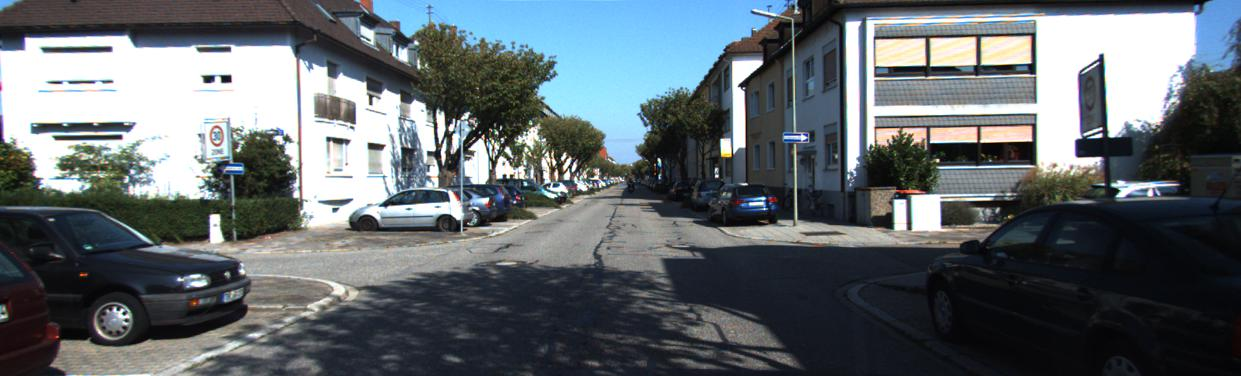

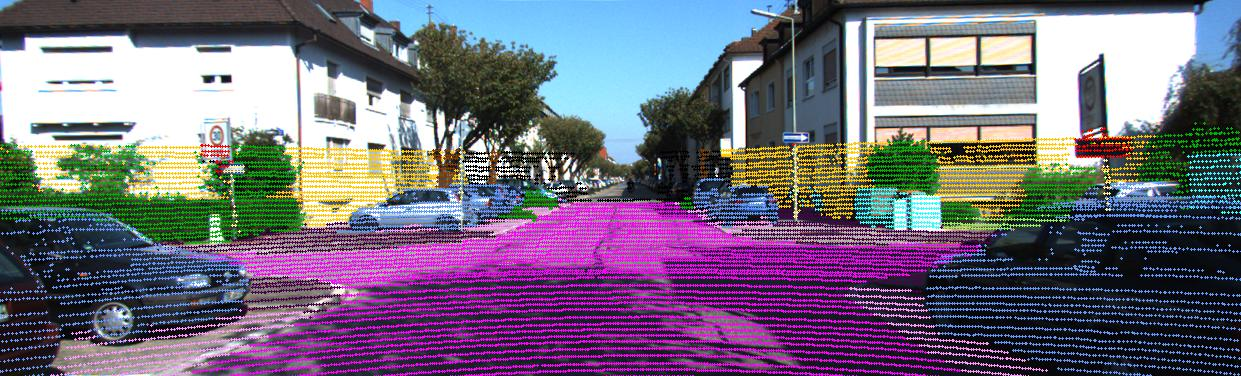

In [24]:
# Problem 2. Projection onto Image Plane
# a. Semantic Segmentation: Displaying Semantic Labels
# refined version 

# load data
segmentation_data_path = os.path.join('data', 'segmentation_data.p')
segmentation_data = load_data(segmentation_data_path)

# point cloud of the scene of type (x [m], y [m], z [m], reflectance intensity [0,1]), (num_points x 4) numpy.array object
velodyne = segmentation_data["velodyne"]

# RGB image received from left RGB camera (1 image per 360° velodyne rotation)
image_2 = segmentation_data["image_2"]

# intrinsic projection matrix to Cam 2 after rectification, (3x4) numpy.array object
P_rect_20 = segmentation_data["P_rect_20"]

# homogeneous velodyne to rectified camera 2 coordinate transformation, (4x4) numpy.array object
T_cam0_velo = segmentation_data["T_cam0_velo"]

# semantic label of each point within the scene, (num_points,) numpy.array object
sem_labels = segmentation_data["sem_label"]

# dictionary mapping numeric semantic labels -> BGR (reversed RGB) color for visualization (e.g. 10: [245, 150, 100])
color_map = segmentation_data["color_map"]

# dictionary mapping numeric semantic labels -> string class (e.g. 10: "car")
labels = segmentation_data["labels"]

# computer vision naming scheme:
#    X is a 3d point
#    x is a 2d point
#    Xh is a 3d homogeneous point
#    xh is a 2d homogeneous point
Xh_world = np.copy(velodyne)
Xh_world[:, 3] = 1
# Velodyne scans are 360°, so we need to get rid of all points that are behind cam2 
# => retain only points whose x-value >= 0.27 (world coordinates)
retain_indices = ( Xh_world[:,0] >= 0.27 )

# project the 3d homogeneous points (world coordinates) to 3d homogeneous points (cam0 coordinates)
Xh_rectified_cam0 = np.matmul(T_cam0_velo, np.transpose(Xh_world))
xh_rectified_cam2 = np.matmul(P_rect_20, Xh_rectified_cam0)

# normalize such that homogeneous coordinate is 1.0 again
xh_rectified_cam2 /= xh_rectified_cam2[2,:]


# prune homogeneous coordinates
x_rectified_cam2 = np.rint(xh_rectified_cam2[:2]).astype(np.int32)

# 1st index goes over each point and 2nd index goes over coordinates of the point
x_rectified_cam2 = np.transpose(x_rectified_cam2)
dimN = np.shape(x_rectified_cam2)[0]

# make a copy to be safe
image_2_semantic_segmentation = np.copy(image_2)

# draw the velodyne points as semantic segmentation points (circles)
for i in range(dimN) :

    if not retain_indices[i] : continue

    x = x_rectified_cam2[i, 0]
    y = x_rectified_cam2[i, 1]
    sem_label = sem_labels[i]
    color = color_map[sem_label[0]][::-1]
  
    cv.circle(
        img = image_2_semantic_segmentation,
        center = (x,y),
        radius = 1,
        color = color,
        thickness = -1,
        lineType = cv.LINE_AA,
        shift = 0
    )

# write output and show results
cv.imwrite("image_2.png", image_2)
showarray(image_2)
cv.imwrite("image_2_semantic_segmentation.png", image_2_semantic_segmentation)
showarray(image_2_semantic_segmentation)

[['Car', 1.76, 1.77, 4.41, -3.82, 1.9, 19.65, 1.67], ['Car', 1.48, 1.65, 4.4, -2.63, 1.99, 27.12, 1.72], ['Car', 1.42, 1.66, 3.64, 0.67, 2.11, 43.31, 1.73], ['Car', 1.44, 1.64, 3.78, 7.44, 2.25, 66.05, 1.92], ['Cyclist', 1.78, 0.69, 1.81, 3.18, 1.87, 24.54, -1.51], ['DontCare', -1.0, -1.0, -1.0, -1000.0, -1000.0, -1000.0, -10.0]]


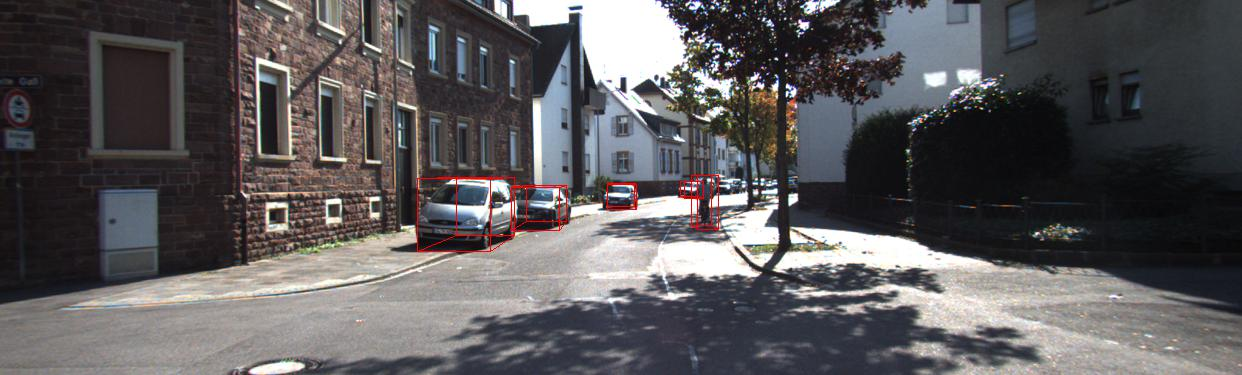

In [25]:
# Problem 2. Projection onto Image Plane
# b. Object Detection: Drawing 3D Bounding Boxes
# REFINED VERSION...


# load data
detection_data_path = os.path.join("data", "detection_data.p")
detection_data = load_data(detection_data_path)

# RGB image received from left RGB camera (1 image per 360° velodyne rotation)
image_2 = detection_data["image_2"]

# intrinsic projection matrix to Cam 2 after rectification, (3x4) numpy.array object
P_rect_20 = detection_data["P_rect_20"]
objects = detection_data["objects"]

# pinhole camera intrinsics from Cam 0 to Cam 2, (3x3) numpy.array object
K_cam0 = detection_data["K_cam0"]
K_cam2 = detection_data["K_cam2"]


# make a copy to be safe
image_2_bounding_boxes = np.copy(image_2)

print(objects)

# draw the bounding boxes
for i in range(np.shape(objects)[0]) :
    # type \in {"Car", "Van", "Truck", "Pedestrian", "Person_sitting", "Cyclist", "Tram", "Misc", "DontCare"}
    obj_type = objects[i][0]

    # the task description says:
    # Project the 3d bounding boxes of all given vehicles, cyclists and pedestrians
    # within the scene of detection data.p to the Cam 2 image
    # Therefore, we assume "Misc" and "DontCare" are not supposed to be shown
    if obj_type in ("Misc", "DontCare") : continue

    # 3D object dimensions in meters, used to construct the bounding box
    height = objects[i][1]
    width  = objects[i][2] / 2
    length = objects[i][3] / 2
    
    # 3D object location x,y,z in Cam0 coordinates in meters, used as the center point of the bounding box
    center = np.array(objects[i][4:7])
    # rotation around Y-axis in Cam 0 coordinates [-pi : pi]
    ry = objects[i][7]
    
    # Bottom face
    corner1 = center + [-width, 0, -length]
    corner2 = center + [width, 0, -length]
    corner3 = center + [width, 0, length]
    corner4 = center + [-width, 0, length]
    
    #Upper face
    corner5 = center + [-width, -height, -length]
    corner6 = center + [width, -height, -length]
    corner7 = center + [width, -height, length]
    corner8 = center + [-width, -height, length]
    
    all_corners = np.stack((corner1, corner2, corner3, corner4, corner5, corner6, corner7, corner8), axis=1)
    
    # create the rotation matrix around y axis
    R = np.array([
        [np.cos(ry), 0, np.sin(ry)],
        [0, 1, 0],
        [-np.sin(ry), 0, np.cos(ry)]
        ]
    )
    
    # homogenous coordinates
    #all_corners = np.matmul(R, all_corners)
    all_corners = np.append(all_corners, np.ones((1,8)),axis=0 ) 
    
    #project points back to cam 2
    all_corners = np.matmul(P_rect_20, all_corners)
    # make homogenous
    all_corners /= all_corners[2,:]
    # prune homogenous coordinates
    all_corners = all_corners[:2].astype(np.int32)
    

    color = (255,0,0)

    #plot closest face 
    cv.rectangle(
        img = image_2_bounding_boxes,
        pt1 = tuple(all_corners[:,0]),
        pt2 = tuple(all_corners[:,5]),
        color = color
    )
    #plot furhest face
    cv.rectangle(
        img = image_2_bounding_boxes,
        pt1 = tuple(all_corners[:,3]),
        pt2 = tuple(all_corners[:,6]),
        color = color
    )
    
    # draw the lines between corners
    cv.line(img = image_2_bounding_boxes, pt1 = tuple(all_corners[:,0]), pt2 = tuple(all_corners[:,3]), color = color)
    cv.line(img = image_2_bounding_boxes, pt1 = tuple(all_corners[:,4]), pt2 = tuple(all_corners[:,7]), color = color)
    cv.line(img = image_2_bounding_boxes, pt1 = tuple(all_corners[:,1]), pt2 = tuple(all_corners[:,2]), color = color)
    cv.line(img = image_2_bounding_boxes, pt1 = tuple(all_corners[:,5]), pt2 = tuple(all_corners[:,6]), color = color)
    
    
# write output and show results
#cv.imwrite("image_2.png", image_2)
#showarray(image_2)
cv.imwrite("image_2_bounding_boxes.png", image_2_bounding_boxes)
showarray(image_2_bounding_boxes)

0.4203125
4.626066
-25.160372


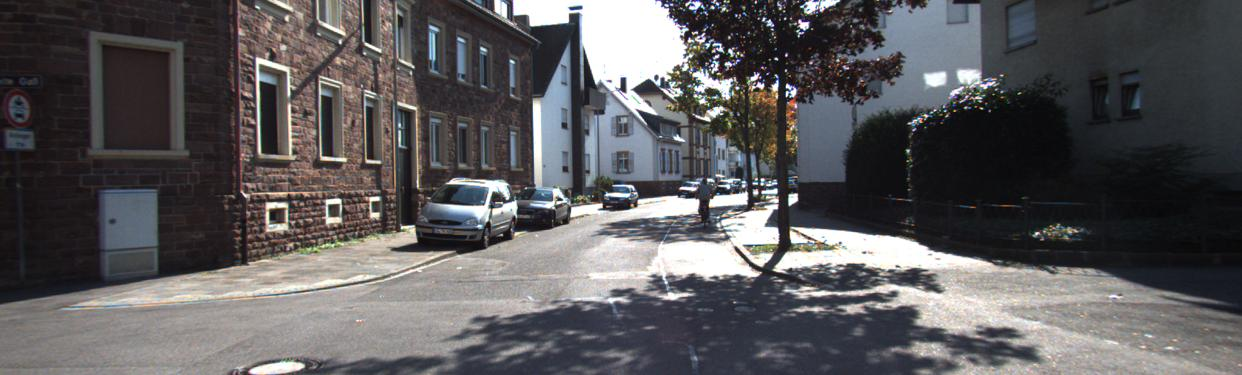

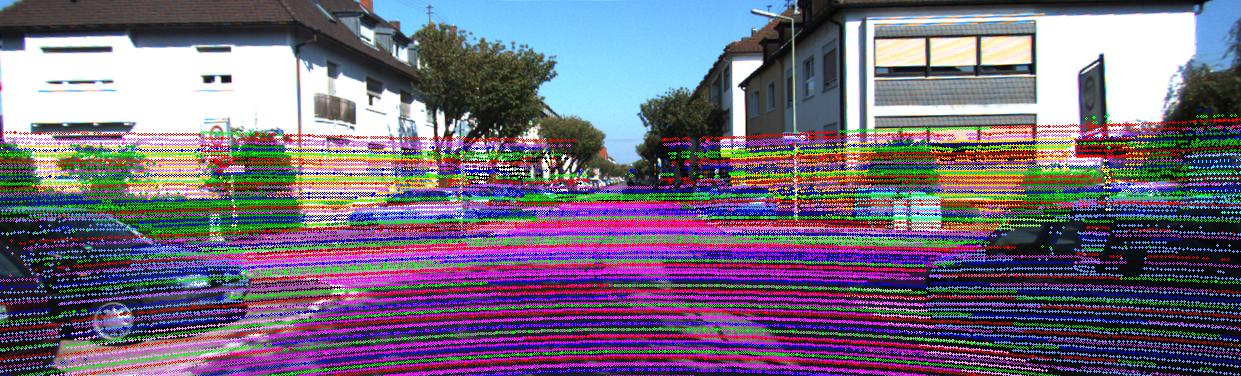

In [69]:
#Problem 3

velodyne = segmentation_data["velodyne"]
distances = np.sqrt(np.sum(np.square(velodyne), axis = 1))

angles = 180 / np.pi * np.arcsin(velodyne[:,2]/distances).reshape(-1,1)
velodyne = np.append(velodyne, angles, axis = 1)

#fix the width
minimum = -24.9
maximum = 2
width = (maximum-minimum) / 64

print(width)
print(np.max(angles))
print(np.min(angles))

#channel = (angles-minimum+0.5*width) // width - 3
channel = (angles - minimum) // width
color = np.mod(channel, 4)

########## Again pre processing as in previous exercise:
# project the 3d homogeneous points (world coordinates) to 3d homogeneous points (cam0 coordinates)
Xh_world = velodyne
Xh_rectified_cam2 = np.matmul(T_cam0_velo, np.transpose(Xh_world))

# normalize such that homogeneous coordinate is 1.0 again
Xh_rectified_cam2 = Xh_rectified_cam2 / Xh_rectified_cam2[3,:]

# project the 3d homogeneous points (cam0 coordinates) to 2d homogeneous points on the rectified cam2 image plane
xh_rectified_cam2 = np.matmul(P_rect_20, Xh_rectified_cam2)

# normalize such that homogeneous coordinate is 1.0 again
xh_rectified_cam2 = xh_rectified_cam2 / xh_rectified_cam2[2,:]

# prune homogeneous coordinates
x_rectified_cam2 = xh_rectified_cam2[0:2]

# convert float32 -> int32 (implicit rounding)
x_rectified_cam2 = x_rectified_cam2.astype(np.int32)

# 1st index goes over each point and 2nd index goes over coordinates of the point
x_rectified_cam2 = np.transpose(x_rectified_cam2)
dimN = np.shape(x_rectified_cam2)[0]
######### End pre processing


for i in range(dimN) :

    if not retain_indices[i] : continue

    x = x_rectified_cam2[i, 0]
    y = x_rectified_cam2[i, 1]
    sem_label = sem_labels[i]
    if color[i] == 0:
        c = (255, 0, 0)
    elif color[i] == 1:
        c = (0, 255, 0)
    elif color[i] == 2:
        c = (0, 0, 255)
    elif color[i] == 3:
        c = (230, 55, 255)
        
    cv.circle(
        img = image_2_semantic_segmentation,
        center = (x,y),
        radius = 1,
        color = c
    )

# write output and show results
cv.imwrite("image_3.png", image_2)
showarray(image_2)
cv.imwrite("image_3_semantic_segmentation.png", image_2_semantic_segmentation)
showarray(image_2_semantic_segmentation)

In [19]:
x_rectified_cam2.shape

(117412, 2)

In [222]:
# Problem 4. Remove Motion Distortion

In [223]:
def load_from_bin(bin_path):
    # load point cloud from a binary file
    obj = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    # ignore reflectivity info
    return obj[:, :3]


In [224]:
# bins = []
bin_directory = 'data/problem_4/velodyne_points/data/'
binnames = [bin_directory + fname for fname in sorted(os.listdir(bin_directory))]
#print(binnames)

bins = np.array( [load_from_bin(binname) for binname in binnames] )
#print(bins.shape)
print(bins[0])
#print(bins[0].shape)
# for i in binnames:
#     bin.append(load_from_bin('data/problem_4/velodyne_points/data/{}'))
print(bins[0].shape)

[[56.893 19.611  2.244]
 [57.931 20.685  2.289]
 [65.631 23.67   2.568]
 ...
 [12.071 -3.181 -5.705]
 [12.06  -3.137 -5.695]
 [12.307 -3.182 -5.811]]
(120462, 3)


In [225]:
# angle = arcsin(-y/(x^2+y^2))
# y = bins[1]
for i in range(len(bins)):
    angles = np.array([-point[1] / (point[0]**2 + point[1]**2) for point in bins[i]]).reshape(-1,1)
    # print(angles.shape)
    bins[i] = np.append(bins[i], angles, axis=1)
    

In [226]:
#bins.shape
#SAVE BINS
np.save('bins.npy', bins)

In [227]:
# t = omega * teta
#we dont need time as we already have angles
#for i in range(len(bins)):
#    time = np.array([point[3] * 2 * np.pi * 10 for point in bins[i]]).reshape(-1,1)
#    # print(angles.shape)
#    bins[i] = np.append(bins[i], time, axis=1)



In [228]:
#bins[0].shape
#np.save('bins2.npy', bins)

In [229]:
def load_oxts_velocity(oxts_f):
    # return the speed of the vehicle given the oxts file
    with open(oxts_f) as f:
        data = [list(map(np.double, line.strip().split(' '))) for line in f]
        speed_f = data[0][8]
        speed_l = data[0][9]
        speed_u = data[0][10]
    return np.array((speed_f, speed_l, speed_u))


def load_oxts_angular_rate(oxts_f):
    # return the angular rate of the vehicle given the oxts file
    with open(oxts_f) as f:
        data = [list(map(np.double, line.strip().split(' '))) for line in f]
        angular_rate_f = data[0][20]
        angular_rate_l = data[0][21]
        angular_rate_u = data[0][22]
    return angular_rate_f, angular_rate_l, angular_rate_u


def compute_timestamps(timestamps_f, ind):
    # return timestamps of the the ind^th sample (line) in seconds
    # in this code, timestamps_f can be 'image_02/timestamps.txt', 'oxts/timestamps.txt', 'velodyne_points/timestamps_start.txt', ...
    #  'velodyne_points/timestamps_end.txt',  or 'velodyne_points/timestamps.txt'. ind is the index (name) of the sample like '0000000003'
    with open(timestamps_f) as f:
        timestamps_ = f.readlines()
        #file_id = file[7:10]
        timestamps_ = timestamps_[int(ind)]
        timestamps_ = timestamps_[11:]
        timestamps_ = np.double(timestamps_[:2]) * 3600 + np.double(timestamps_[3:5]) * 60 + np.double(timestamps_[6:])
    return timestamps_



In [230]:
#create a 430x6 array with timestamp and x,y,z (position of the car), yaw
load_oxts_angular_rate('data/problem_4/oxts/data/0000000000.txt')

(-0.024530117470279, 0.0093976549070755, 0.048131193935335)

In [231]:
#angularRates = np.zeros((430,3))
print(angularRates)

[[-0.02453012  0.00939765  0.04813119]
 [-0.01433264  0.01226739  0.05274628]
 [ 0.00903663  0.00620961  0.05627243]
 ...
 [ 0.00987513 -0.01102773 -0.16432511]
 [ 0.01643113 -0.01021504 -0.16201645]
 [ 0.01369061 -0.00457722 -0.15492204]]


In [232]:
#Extrace angular velocity rates per each image taken


oxtsDirectory = 'data/problem_4/oxts/data/'
oxtsNames = [oxtsDirectory + fname for fname in sorted(os.listdir(oxtsDirectory))]

#bins = np.array( [load_from_bin(binname) for binname in binnames] )

angularRates = np.array([load_oxts_angular_rate(name) for name in oxtsNames])
angularRatesZ = angularRates[:, 2]

In [233]:
angularRatesZ.shape

(430,)

In [234]:
#Extrace linear velocity rates per each image taken
velocity = np.array([load_oxts_velocity(name) for name in oxtsNames])
velocity

array([[ 1.60181579e+01,  2.73237281e-02, -6.87663241e-02],
       [ 1.60123473e+01,  3.35919832e-02, -7.42137438e-02],
       [ 1.60032342e+01,  5.29077020e-02, -7.96002626e-02],
       ...,
       [ 1.15605588e+01, -9.23368227e-03, -4.42863702e-01],
       [ 1.15949753e+01, -4.41117167e-03, -4.38095681e-01],
       [ 1.16338151e+01,  2.02703183e-03, -4.24701040e-01]])

In [235]:
timestamps = np.array([compute_timestamps('data/problem_4/oxts/timestamps.txt',i) for i in range(430)])
#np.diff(timestamps)
timestamps = np.append(timestamps, np.average(np.diff(timestamps)))
timestamps.shape


(431,)

In [236]:
#Integration to find the pose per each camera trigger
angularPosition = np.array([ (timestamps[i+1]-timestamps[i]) * 
                            angularRatesZ[i] for i in range(430)])

In [237]:
angularPosition.shape
timestamps.shape
angularRatesZ.shape

(430,)

In [238]:
angularPosition.shape

(430,)

In [239]:
linearPosition = np.array([ (timestamps[i+1]-timestamps[i]) * 
                            velocity[i] for i in range(430)])


In [240]:
linearPosition.shape

(430, 3)

In [241]:
angularPositionInterpolated = np.zeros((430 * 360,1))

In [242]:
points = np.linspace(0, 430, 430*360)
x = np.arange(430)
angularPositionInterpolated = np.interp(points, x, angularPosition)

In [243]:
linearPositionInterpolated = np.array([ np.interp(points, x, linearPosition[:,i])
for i in range(3) ]).T

In [244]:
linearPositionInterpolated.shape

(154800, 3)

In [245]:
translations = np.diff(linearPosition)
transformation_matrices = np.empty((linearPositionInterpolated.shape[0],4,4))
for i in range(430):
    
    for j in range(360):
        
        alpha = angularPositionInterpolated[j+360*i] - angularPositionInterpolated[360*i]
        translation = linearPositionInterpolated[j+i*360] - linearPositionInterpolated[i*360]
        xt = translation[0]
        yt = translation[1]
        zt = translation[2]
        T = np.array([[np.cos(alpha), -np.sin(alpha), 0, xt],
                      [np.sin(alpha), np.cos(alpha), 0, yt],
                      [0, 0, 1, zt],
                      [0, 0, 0, 1]
                     ])
        transformation_matrices[i] = T
print(transformation_matrices.shape)

(154800, 4, 4)


In [246]:
# Per each Lidar rotation, an image is taken.
# One lidar rotation (and one image taken at the beginning):
    #360 degrees, each point is taken at one degree. Assign to each point its transformation 
    #matrix
    #at degree 30 of image 5, position is interpolatedPosition[30 + 5*360]
bins[0]
#bins[:,]np.rint

array([[ 5.68930016e+01,  1.96110001e+01,  2.24399996e+00,
        -5.41530161e-03],
       [ 5.79309998e+01,  2.06849995e+01,  2.28900003e+00,
        -5.46662539e-03],
       [ 6.56309967e+01,  2.36700001e+01,  2.56800008e+00,
        -4.86266953e-03],
       ...,
       [ 1.20710001e+01, -3.18099999e+00, -5.70499992e+00,
         2.04135585e-02],
       [ 1.20600004e+01, -3.13700008e+00, -5.69500017e+00,
         2.02016461e-02],
       [ 1.23070002e+01, -3.18199992e+00, -5.81099987e+00,
         1.96921318e-02]])

In [247]:
for i in range(430):
    bins[i] = bins[i][:,:4]

In [248]:
bins[1]

array([[ 5.40989990e+01,  1.89319992e+01,  2.14700007e+00,
        -5.76295113e-03],
       [ 5.56819992e+01,  1.96830006e+01,  2.20600009e+00,
        -5.64321490e-03],
       [ 5.47599983e+01,  1.95510006e+01,  2.17499995e+00,
        -5.78278155e-03],
       ...,
       [ 3.72799993e+00, -1.40999997e+00, -1.74199998e+00,
         8.87569287e-02],
       [ 3.73900008e+00, -1.40699995e+00, -1.74699998e+00,
         8.81591593e-02],
       [ 3.73600006e+00, -1.39300001e+00, -1.74300003e+00,
         8.76202831e-02]])

In [280]:
for j in range(430):
    #per one image/rotation
    for i in range(360):
        indices = np.where(bins[j][:,3]==i)[0]
            
        projBin = transformation_matrices[i + 360 * j] @ \
        np.append(bins[j][indices,:3],np.ones((indices.shape[0],1) ), axis=1).T
        
        np.save('ProjBins/' + 'scene' + str(j),projBin)
        

In [281]:
projBins

NameError: name 'projBins' is not defined